# Process GWTC data - NEW

This notebook uses the PE samples from the GWTC-2.1 and GWTC-3 data release. Additionally, p_theta is calculated both with a KDE from prior samples and analytically for comparative purposes.

In [1]:
import sys
sys.path.insert(1, '../effective-spin-priors')
sys.path.insert(1, '../populations/utils')

In [3]:
import h5py
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from astropy import cosmology
from astropy.cosmology import z_at_value
import astropy.units as u
cosmo = cosmology.Planck15

from scipy.interpolate import UnivariateSpline
from scipy.stats import gaussian_kde
from tqdm import tqdm

import bilby

sys.path.append('../')
from populations.utils import bounded_Nd_kde
from effectivespinpriors.priors import chi_effective_prior_from_isotropic_spins

In [15]:
output_directory = '../gwtc3events/'
removed_events_directory = '../gwtc3events_removed/'

#where PE files are stored
GWTC21_path = '/home/april.cheng/modelselect/data/raw_data/GWTC-2.1'
GWTC3_path = '/home/april.cheng/modelselect/data/raw_data/GWTC-3'

#all GWs with FAR < 1/yr
gw_names_path = '/home/april.cheng/modelselect/data/gw_names.txt'
with open(gw_names_path, 'r') as f:
    gw_names = [line.strip() for line in f.readlines()]

print(gw_names)

['GW150914_095045', 'GW151012_095443', 'GW151226_033853', 'GW170104_101158', 'GW170608_020116', 'GW170729_185629', 'GW170809_082821', 'GW170814_103043', 'GW170818_022509', 'GW170823_131358', 'GW190408_181802', 'GW190412_053044', 'GW190413_134308', 'GW190421_213856', 'GW190503_185404', 'GW190512_180714', 'GW190513_205428', 'GW190517_055101', 'GW190519_153544', 'GW190521_030229', 'GW190521_074359', 'GW190527_092055', 'GW190602_175927', 'GW190620_030421', 'GW190630_185205', 'GW190701_203306', 'GW190706_222641', 'GW190707_093326', 'GW190708_232457', 'GW190720_000836', 'GW190727_060333', 'GW190728_064510', 'GW190803_022701', 'GW190828_063405', 'GW190828_065509', 'GW190910_112807', 'GW190915_235702', 'GW190924_021846', 'GW190925_232845', 'GW190929_012149', 'GW190930_133541', 'GW191105_143521', 'GW191109_010717', 'GW191127_050227', 'GW191129_134029', 'GW191204_171526', 'GW191215_223052', 'GW191216_213338', 'GW191222_033537', 'GW191230_180458', 'GW200112_155838', 'GW200128_022011', 'GW200129_0

In [12]:
# create interpolant for determining redshifts from luminosity distances
dL_max = 20000 # Mpc
dL_vals = np.linspace(0.0001, dL_max, 20000)
redshift_vals = np.asarray([z_at_value(cosmo.luminosity_distance, dL*u.Mpc) for dL in dL_vals])
z_from_dL = UnivariateSpline(dL_vals, redshift_vals)
dzdL_from_dL = z_from_dL.derivative()

def dL_to_redshift(dL):
    # Input distance in Mpc
    # Use interpolant above to speed this up
    return z_from_dL(dL)

In [13]:
# conversion function

def m1m2_to_mchirp(m1,m2):
    return (m1*m2)**(3./5) / (m1+m2)**(1./5)

def m1m2_to_mtot(m1,m2):
    return m1+m2

def m1m2_to_q(m1,m2):
    # q is defined as m2/m1 with m2<=m1
    q = m2/m1
    pos_idxs = np.argwhere(q > 1)
    q[pos_idxs] = m1[pos_idxs]/m2[pos_idxs]
    return q

def m1m2_to_eta(m1,m2):
    eta = (m1*m2) / (m1+m2)**2
    return eta

def components_to_chieff(m1,m2,a1,a2,costilt1,costilt2):
    return (m1*a1*costilt1 + m2*a2*costilt2) / (m1+m2)

def prob(priors, sample): #why is this not predefined in bilby lmfao
    return np.product(np.array([priors[key].prob(sample[key]) for key in sample]), axis = 0)

In [14]:
np.random.seed(101) #set for reproducability

## GWTC-2.1

In [21]:
no_prior = [] #some samples have no analytic prior given; do these later separately
prior_params = ['mass_1', 'mass_2', 'chirp_mass', 'mass_ratio', 'luminosity_distance']
prior_params_z = ['mass_1', 'mass_2', 'chirp_mass', 'mass_ratio', 'redshift']

for path in (GWTC21_path, GWTC3_path):
    
    os.chdir(path)

    for filename in sorted(os.listdir(path)):

        gw_name = filename.split('-')[-1].split('_PE')[0]
        if gw_name+'.hdf5' in os.listdir(output_directory):
            print(f'skipping {gw_name} - done')
            continue

        #use uniform comoving volume prior
        if 'nocosmo' in filename or 'prior' in filename:
            continue 

        if gw_name in gw_names: #only use confident BBHs

            print(gw_name)

            with h5py.File(filename, 'r') as f:

                #some events are missing priors (data release error)
                if 'analytic' not in f['C01:IMRPhenomXPHM']['priors'].keys(): 
                    no_prior_2.append(gw_name)
                    print(f'skipping {gw_name} - no prior')
                    continue

                #read in PE samples
                df = pd.DataFrame(np.asarray(f['C01:Mixed']['posterior_samples'])) 

                # luminosity distance and redshift
                dL = np.asarray(df['luminosity_distance'])
                z = np.asarray(df['redshift'])

                # chirp mass and total mass (source frame)
                m1_src = np.asarray(df['mass_1_source'])
                m2_src = np.asarray(df['mass_2_source'])
                mchirp = np.asarray(df['chirp_mass_source'])
                mtot = np.asarray(df['total_mass_source'])

                # q and eta
                q = np.asarray(df['mass_ratio'])
                eta = np.asarray(df['symmetric_mass_ratio'])

                # chieff
                chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['a_1']), np.asarray(df['a_2']), \
                                              np.asarray(df['cos_tilt_1']), np.asarray(df['cos_tilt_2']))

                new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 
                                       'chieff':chieff, 'dL':dL, 'z':z})         

                # calculate prior at posterior points
                with open(gw_name+'_prior.prior', 'w') as prior_f:
                    a_max = float(f['C01:IMRPhenomXPHM']['priors']['analytic']['a_1'][0].\
                                  decode('UTF8').split('maximum=')[1].split(',')[0])
                    for param in prior_params:
                        if param in ['chirp_mass', 'mass_ratio']:
                            prior_f.write(param + ' = bilby.gw.prior.' + 
                                          f['C01:IMRPhenomXPHM']['priors']['analytic'][param][0].decode('UTF8') + '\n')
                        else:
                            prior_f.write(param + ' = ' + 
                                          f['C01:IMRPhenomXPHM']['priors']['analytic'][param][0].decode('UTF8') + '\n')

            priors = bilby.core.prior.PriorDict(filename=gw_name+'_prior.prior')

            ld_min = priors['luminosity_distance'].minimum
            ld_max = priors['luminosity_distance'].maximum
            z_min = dL_to_redshift(ld_min)
            z_max = dL_to_redshift(ld_max)

            priors.pop('luminosity_distance')
            priors['redshift'] = bilby.gw.prior.UniformSourceFrame(z_min, z_max, name='redshift')

            p = prob(priors, df[prior_params_z]) #mchirp_det, q, z

            p *= (1 + new_df['z']) #mchirp_det to mchirp_source jacobian

            # apply chieff jacobian from tcallister's github
            p_chieffs = []
            for q_i, chieff_i in zip(new_df['q'], new_df['chieff']):
                p_chieffs.append(chi_effective_prior_from_isotropic_spins(q_i, a_max, chieff_i)[0]) #p(chieff | q)
            p *= np.array(p_chieffs)

            new_df['p_theta_jcb'] = p

            new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key='combined')

# remove GW190521
os.rename(os.path.join(output_directory, 'GW190521_030229.hdf5'), os.path.join(removed_events_directory, 'GW190521_030229.hdf5'))

skipping GW150914_095045 - done
skipping GW150914_095045 - done
skipping GW151012_095443 - done
skipping GW151012_095443 - done
skipping GW151226_033853 - done
skipping GW151226_033853 - done
skipping GW170104_101158 - done
skipping GW170104_101158 - done
skipping GW170608_020116 - done
skipping GW170608_020116 - done
skipping GW170729_185629 - done
skipping GW170729_185629 - done
skipping GW170809_082821 - done
skipping GW170809_082821 - done
skipping GW170814_103043 - done
skipping GW170814_103043 - done
skipping GW170818_022509 - done
skipping GW170818_022509 - done
skipping GW170823_131358 - done
skipping GW170823_131358 - done
skipping GW190408_181802 - done
skipping GW190408_181802 - done
skipping GW190412_053044 - done
skipping GW190412_053044 - done
skipping GW190413_052954 - done
skipping GW190413_052954 - done
skipping GW190413_134308 - done
skipping GW190413_134308 - done
skipping GW190421_213856 - done
skipping GW190421_213856 - done
skipping GW190503_185404 - done
skipping

In [10]:
no_prior_2

['GW170608_020116',
 'GW190707_093326',
 'GW190720_000836',
 'GW190725_174728',
 'GW190728_064510',
 'GW190924_021846']

## GWTC-3

In [122]:
no_prior_3 = [] #some samples have no analytic prior given; do these later separately
prior_params = ['mass_1', 'mass_2', 'chirp_mass', 'mass_ratio', 'luminosity_distance']
prior_params_z = ['mass_1', 'mass_2', 'chirp_mass', 'mass_ratio', 'redshift']

os.chdir(GWTC3_path)

for filename in sorted(os.listdir(GWTC3_path)):
    
    gw_name = filename.split('-')[-1].split('_PE')[0]
    #use uniform comoving volume prior, exclude GW190521_030229
    if 'nocosmo' in filename or 'prior' in filename or 'GW190521_030229' in filename:
        continue 

    if gw_name in gw_names: #only use confident BBHs

        print(gw_name)
        
        calc_p_theta = False
        calc_p_theta_jcb = True
        
        with h5py.File(filename, 'r') as f:
            
            if 'analytic' not in f['C01:IMRPhenomXPHM']['priors'].keys(): #some events are missing priors for some reason
                no_prior_2.append(gw_name)
                print(f'skipping {gw_name} - no prior')
                continue
            
            #get posterior samples
            
            if gw_name+'.hdf5' in os.listdir(output_directory):
                new_df = pd.read_hdf(os.path.join(output_directory, gw_name+'.hdf5'))
                
                redshift = np.array(new_df['z'])
                mass_1 = np.array(new_df['m1']) * (1 + redshift) #get detector frame
                mass_2 = np.asarray(new_df['m2']) * (1 + redshift)
                chirp_mass = np.array(new_df['mchirp']) * (1 + redshift)
                mass_ratio = np.array(new_df['q'])
                df = pd.DataFrame({'mass_1': mass_1, 'mass_2': mass_2, 'chirp_mass': chirp_mass, 'mass_ratio': mass_ratio, 'redshift': redshift})
                
            else:
                df = pd.DataFrame(np.asarray(f['C01:Mixed']['posterior_samples'])) 
                if len(df) > 10000:
                    df = df.sample(10000) #cap at 10000 posterior samples

                # luminosity distance and redshift
                dL = np.asarray(df['luminosity_distance'])
                z = np.asarray(df['redshift'])

                # chirp mass and total mass (source frame)
                m1_src = np.asarray(df['mass_1_source'])
                m2_src = np.asarray(df['mass_2_source'])
                mchirp = np.asarray(df['chirp_mass_source'])
                mtot = np.asarray(df['total_mass_source'])

                # q and eta
                q = np.asarray(df['mass_ratio'])
                eta = np.asarray(df['symmetric_mass_ratio'])

                # chieff
                chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['a_1']), np.asarray(df['a_2']), \
                                              np.asarray(df['cos_tilt_1']), np.asarray(df['cos_tilt_2']))
                
                new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 
                                       'chieff':chieff, 'dL':dL, 'z':z})         
                
            # get prior

            prior = pd.DataFrame()
            for key in f['C01:IMRPhenomXPHM']['priors']['samples'].keys():
                if 'recalib' in key:
                    continue
                prior[key] = np.asarray(f['C01:IMRPhenomXPHM']['priors']['samples'][key]) 
            
            #get p_theta from KDE
            
            if calc_p_theta:

                X = np.atleast_2d([prior['chirp_mass_source'],prior['mass_ratio'],prior['chi_eff'],prior['redshift']])
                Bounds = np.atleast_2d([(prior['chirp_mass_source'].min(),prior['chirp_mass_source'].max()), 
                                        (prior['mass_ratio'].min(),prior['mass_ratio'].max()),
                                        (prior['chi_eff'].min(),prior['chi_eff'].max()), (prior['redshift'].min(),prior['redshift'].max())])

                prior_kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=0.05)

                p_theta = []
                post_samples = np.atleast_2d([np.asarray(df_new['mchirp']), 
                                              np.asarray(df_new['q']),
                                              np.asarray(df_new['chieff']),
                                              np.asarray(df_new['z'])])
                for p in tqdm(post_samples.T):
                    p_theta.append(prior_kde(np.atleast_2d(p).T))
                p_theta = np.asarray([item for sublist in p_theta for item in sublist])

                new_df['p_theta'] = p_theta

            #get p_theta analytically if possible

            if calc_p_theta_jcb:

                with open(gw_name+'_prior.prior', 'w') as prior_f:
                    a_max = float(f['C01:IMRPhenomXPHM']['priors']['analytic']['a_1'][0].decode('UTF8').split('maximum=')[1].split(',')[0])
                    for param in prior_params:
                        if param in ['chirp_mass', 'mass_ratio']:
                            prior_f.write(param + ' = bilby.gw.prior.' + f['C01:IMRPhenomXPHM']['priors']['analytic'][param][0].decode('UTF8') + '\n')
                        else:
                            prior_f.write(param + ' = ' + f['C01:IMRPhenomXPHM']['priors']['analytic'][param][0].decode('UTF8') + '\n')

                priors = bilby.core.prior.PriorDict(filename=gw_name+'_prior.prior')

                ld_min = priors['luminosity_distance'].minimum
                ld_max = priors['luminosity_distance'].maximum
                z_min = dL_to_redshift(ld_min)
                z_max = dL_to_redshift(ld_max)

                priors.pop('luminosity_distance')
                priors['redshift'] = bilby.gw.prior.UniformSourceFrame(z_min, z_max, name='redshift')
                

                p = prob(priors, df[prior_params_z]) #mchirp_det, q, z

                p *= (1 + new_df['z']) #mchirp_det to mchirp_source jacobian

                #get chieff prior from tcallister

                p_chieffs = []
                for q_i, chieff_i in zip(new_df['q'], new_df['chieff']):
                    p_chieffs.append(chi_effective_prior_from_isotropic_spins(q_i, a_max, chieff_i)[0]) #p(chieff | q)

                p *= np.array(p_chieffs)

                new_df['p_theta_jcb'] = p
            
        new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key='combined')

GW191103_012549
GW191105_143521
GW191109_010717
GW191127_050227
GW191129_134029
GW191204_171526
GW191215_223052
GW191216_213338
GW191222_033537
GW191230_180458
GW200112_155838
GW200128_022011
GW200129_065458
GW200202_154313
GW200208_130117
GW200209_085452
GW200216_220804
GW200219_094415
GW200224_222234
GW200225_060421
GW200302_015811
GW200311_115853
GW200316_215756


## Events that are missing analytical prior

I ended up getting the priors from each event's repo:

- GW170608_020116 - https://git.ligo.org/pe/O2/GW170608/-/blob/master/C01_offline/ProdF13.prior 
- GW190707_093326 - https://git.ligo.org/pe/O3/S190707q/-/blob/master/C01_offline/ProdF9.prior 
- GW190720_000836 - https://git.ligo.org/pe/O3/S190720a/-/blob/master/C01_offline/ProdF11.prior
- GW190725_174728 - https://git.ligo.org/pe/O3/S190725t/-/blob/master/C01_offline/ProdF15.prior
- GW190728_064510 - https://git.ligo.org/pe/O3/S190728q/-/blob/master/C01_offline/ProdF5.prior
- GW190924_021846 - https://git.ligo.org/pe/O3/S190924h/-/blob/master/C01_offline/ProdF7.prior

In [8]:
no_prior = ['GW170608_020116',
 'GW190707_093326',
 'GW190720_000836',
 'GW190725_174728',
 'GW190728_064510',
 'GW190924_021846']

In [9]:
os.chdir(GWTC21_path)

In [49]:
prior_params_z = ['mass_1', 'mass_2', 'chirp_mass', 'mass_ratio', 'redshift']

for gw_name in no_prior:
    
    print(gw_name)
    
    with h5py.File(f'IGWN-GWTC2p1-v2-{gw_name}_PEDataRelease_mixed_cosmo.h5') as f:
        df = pd.DataFrame(np.asarray(f['C01:Mixed']['posterior_samples'])) 

    # luminosity distance and redshift
    dL = np.asarray(df['luminosity_distance'])
    z = np.asarray(df['redshift'])

    # chirp mass and total mass (source frame)
    m1_src = np.asarray(df['mass_1_source'])
    m2_src = np.asarray(df['mass_2_source'])
    mchirp = np.asarray(df['chirp_mass_source'])
    mtot = np.asarray(df['total_mass_source'])

    # q and eta
    q = np.asarray(df['mass_ratio'])
    eta = np.asarray(df['symmetric_mass_ratio'])

    # chieff
    chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['a_1']), np.asarray(df['a_2']), \
                                  np.asarray(df['cos_tilt_1']), np.asarray(df['cos_tilt_2']))

    new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 
                           'chieff':chieff, 'dL':dL, 'z':z})  
    
    bb_priors = bilby.core.prior.PriorDict(filename=f'{gw_name}_prior.prior')
    
    z_min = dL_to_redshift(bb_priors['luminosity_distance'].minimum)
    z_max = dL_to_redshift(bb_priors['luminosity_distance'].maximum)
    a_max = bb_priors['a_1'].maximum

    bb_priors.pop('luminosity_distance')
    bb_priors['redshift'] = bilby.gw.prior.UniformSourceFrame(z_min, z_max, name='redshift')

    priors = bilby.core.prior.PriorDict()
    for param in prior_params_z:
        priors[param] = bb_priors[param]

    p = prob(priors, df[prior_params_z]) #mchirp_det, q, z

    p *= (1 + new_df['z']) #mchirp_det to mchirp_source jacobian

    #get chieff prior from tcallister

    p_chieffs = []
    for q_i, chieff_i in zip(new_df['q'], new_df['chieff']):
        p_chieffs.append(chi_effective_prior_from_isotropic_spins(q_i, a_max, chieff_i)[0]) #p(chieff | q)

    p *= np.array(p_chieffs)

    new_df['p_theta_jcb'] = p
    
    new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key='combined')

GW170608_020116
GW190707_093326
GW190720_000836
GW190725_174728
GW190728_064510
GW190924_021846


## Check if the analytical priors I used are good

In [74]:
fns_2 = os.listdir(GWTC21_path)
fns_3 = os.listdir(GWTC3_path)

def check_mass_prior(gw_name):
    
    if any([gw_name in fn for fn in fns_2]):
        os.chdir(GWTC21_path)
        fn = f'IGWN-GWTC2p1-v2-{gw_name}_PEDataRelease_mixed_cosmo.h5'
    elif any([gw_name in fn for fn in fns_3]):
        os.chdir(GWTC3_path)
        fn = f'IGWN-GWTC3p0-v1-{gw_name}_PEDataRelease_mixed_cosmo.h5'
    else:
        print('gw not found')
        return
        
    with h5py.File(fn, 'r') as f:
        m1 = np.asarray(f['C01:IMRPhenomXPHM']['priors']['samples']['mass_1']) 
        m2 = np.asarray(f['C01:IMRPhenomXPHM']['priors']['samples']['mass_2']) 
    
    n = len(m1)
    
    fig, axes = plt.subplots(2, 1, figsize=(5,5), sharex=True, sharey=True)
    _ = axes[0].hist2d(m1, m2, bins=50)
    axes[0].set_aspect('equal', adjustable='box')
        
    bb_prior = bilby.gw.prior.BBHPriorDict(filename=gw_name+'_prior.prior')
    bb_prior.pop('luminosity_distance')
    bb_samples = bb_prior.sample(n)
    m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(bb_samples['chirp_mass'], bb_samples['mass_ratio'])
    
    _ = axes[1].hist2d(m1, m2, bins=50)
    axes[1].set_aspect('equal', adjustable='box')

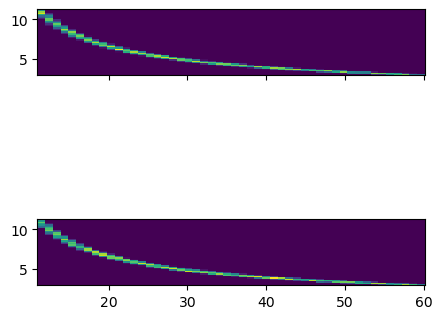

In [75]:
check_mass_prior('GW191204_171526')

In [21]:
output_directory_old = '/home/april.cheng/modelselect/data/events_processed'

In [136]:
bb_prior = bilby.gw.prior.BBHPriorDict({'mass_1': bilby.core.prior.base.Constraint(minimum=1, maximum=1000, name='mass_1'),
                                      'mass_2': bilby.core.prior.base.Constraint(minimum=1, maximum=1000, name='mass_2'),
                                      'chirp_mass': bilby.gw.prior.UniformInComponentsChirpMass(minimum=1, maximum=200, name='chirp_mass'),
                                      'mass_ratio': bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.05, maximum=1.0, name='chirp_mass'),
                                      'luminosity_distance': bilby.core.prior.analytical.PowerLaw(alpha=2, minimum=10, maximum=10000, 
                                                                                                  name='luminosity_distance', unit='Mpc', boundary=None)})

In [137]:
#in GWTC-1

#get prior samples to set bounds

with h5py.File('/home/april.cheng/modelselect/data/raw_data/GWTC-1/GW170608_GWTC-1.hdf5') as f:
    prior = pd.DataFrame(np.array(f['prior']))

prior['redshift'] = dL_to_redshift(prior['luminosity_distance_Mpc'])
prior['mass_ratio'] = prior['m2_detector_frame_Msun']/prior['m1_detector_frame_Msun']
prior['chirp_mass'] = m1m2_to_mchirp(prior['m1_detector_frame_Msun'], prior['m2_detector_frame_Msun'])
prior['chi_eff'] = components_to_chieff(prior['m1_detector_frame_Msun'], prior['m2_detector_frame_Msun'], prior['spin1'], 
                                        prior['spin2'], prior['costilt1'], prior['costilt2'])

#create bilby prior
bb_prior['mass_1'].minimum = prior['m2_detector_frame_Msun'].min()
bb_prior['mass_1'].maximum = prior['m1_detector_frame_Msun'].max()
bb_prior['mass_2'].minimum = prior['m2_detector_frame_Msun'].min()
bb_prior['mass_2'].maximum = prior['m1_detector_frame_Msun'].max()
bb_prior['chirp_mass'].minimum = prior['chirp_mass'].min()
bb_prior['chirp_mass'].maximum = prior['chirp_mass'].max()
bb_prior['mass_ratio'].minimum = prior['mass_ratio'].min()
bb_prior['mass_ratio'].maximum = prior['mass_ratio'].max()
bb_prior['luminosity_distance'].minimum = prior['luminosity_distance_Mpc'].min()
bb_prior['luminosity_distance'].maximum = prior['luminosity_distance_Mpc'].max()

print(bb_prior)

{'mass_1': Constraint(minimum=3.277158996924418, maximum=36.37699425186862, name='mass_1', latex_label='$m_1$', unit=None), 'mass_2': Constraint(minimum=3.277158996924418, maximum=36.37699425186862, name='mass_2', latex_label='$m_2$', unit=None), 'chirp_mass': bilby.gw.prior.UniformInComponentsChirpMass(minimum=8.000008073998705, maximum=8.999787780377527, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None), 'mass_ratio': bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.10005922733229014, maximum=0.9997064359951763, name='chirp_mass', latex_label='$q$', unit=None, boundary=None, equal_mass=False), 'luminosity_distance': PowerLaw(alpha=2, minimum=92.66753110539769, maximum=2031.8898693347667, name='luminosity_distance', latex_label='$d_L$', unit='Mpc', boundary=None)}


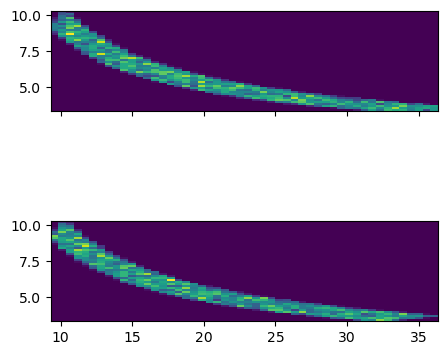

In [138]:
#check that the mass prior is correct
fig, axes = plt.subplots(2, 1, figsize=(5,5), sharex=True, sharey=True)

bb_samples = bb_prior.sample(len(prior))
m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(bb_samples['chirp_mass'], bb_samples['mass_ratio'])
_ = axes[0].hist2d(m1, m2, bins=50)
axes[0].set_aspect('equal', adjustable='box')

_ = axes[1].hist2d(prior['m1_detector_frame_Msun'], prior['m2_detector_frame_Msun'], bins=50)
axes[1].set_aspect('equal', adjustable='box')

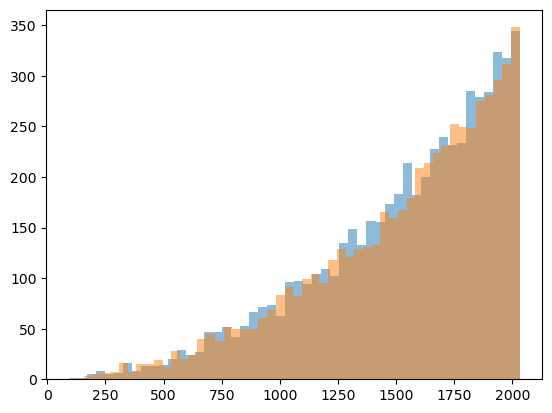

In [102]:
#check that luminosity distance prior is correct
_ = plt.hist(prior['luminosity_distance_Mpc'], bins=50, alpha=0.5)
_ = plt.hist(bb_samples['luminosity_distance'], bins=50, alpha=0.5)

In [126]:
new_df = pd.read_hdf(os.path.join(output_directory_old, 'GW170608.hdf5'))
prior_params = ['mass_1', 'mass_2', 'chirp_mass', 'mass_ratio', 'luminosity_distance']

luminosity_distance = np.array(new_df['dL'])
redshift = np.array(new_df['z'])
mass_1 = np.array(new_df['m1']) * (1 + redshift) #get detector frame
mass_2 = np.asarray(new_df['m2']) * (1 + redshift)
chirp_mass = np.array(new_df['mchirp']) * (1 + redshift)
mass_ratio = np.array(new_df['q'])
df = pd.DataFrame({'mass_1': mass_1, 'mass_2': mass_2, 'chirp_mass': chirp_mass, 'mass_ratio': mass_ratio, 
                   'redshift': redshift, 'luminosity_distance': luminosity_distance})

p = prob(bb_prior, df[prior_params]) #mchirp_det, q, dL

#apply jacobians

p *= (1 + new_df['z']) #mchirp_det to mchirp_source jacobian
p /= dzdL_from_dL(luminosity_distance) #P(z) = P(dL) * d(dL)/dz
#get chieff prior from tcallister
p_chieffs = []
for q_i, chieff_i in zip(new_df['q'], new_df['chieff']):
    p_chieffs.append(chi_effective_prior_from_isotropic_spins(q_i, a_max, chieff_i)[0]) #p(chieff | q)
p *= np.array(p_chieffs)

new_df['p_theta_jcb'] = p

new_df.to_hdf(os.path.join(output_directory, 'GW170608_020116.hdf5'), key='combined')